# Plot qPCR to analyze RNA loss due to filtering and clarifying supernatant

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_ESCRT_inhibitor"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_ESCRT_inhibitor_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

print(cq_raw.shape)
cq_raw.head()

(12, 13)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
0,A01,SYBR,mCherry,Unkn-01,38-1,NaN,28.538764,28.300608,0.209501,27.843487,1.444724,33.541876,5.035458
1,A03,SYBR,mCherry,Unkn-03,38-3,NaN,20.412622,20.471170,0.128109,12185.596956,4.085847,11698.345408,1090.854972
2,A11,SYBR,mCherry,Unkn-11,38-11,NaN,29.510194,28.989742,0.457205,13.458404,1.128994,20.605586,6.343001
3,B01,SYBR,mCherry,Unkn-01,38-1,NaN,28.218296,28.300608,0.209501,35.390018,1.548881,33.541876,5.035458
4,B03,SYBR,mCherry,Unkn-03,38-3,NaN,20.382795,20.471170,0.128109,12460.654034,4.095541,11698.345408,1090.854972


# Preprocess data

## Calculate total starting molecules

In [5]:
# Calculate normalization for input volume
DILUTION_FACTORS = (400/140) * (42/20) * (61/10) * (20/1)

In [6]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [7]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [8]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
38-1,33.541876,5.035458,4.121080e+06,6.186751e+05
38-11,20.605586,6.343001,2.531679e+06,7.793247e+05
38-15,5.340679,3.906489,6.561757e+05,4.799657e+05
38-3,11698.345408,1090.854972,1.437302e+09,1.340265e+08


## Censor by lower limit of quantification

In [9]:
# Lower limit of quantification is set based on maximum signal from no template control (NTC) wells.

LOD = cq_raw.set_index("Sample").loc["38-15", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 1206056.4696794944


In [10]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

# Visualize RNA abundance with ESCRT inhibitor

In [11]:
# Choose samples
index_ordered = ["38-3", "38-1", "38-11"]

In [12]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

# Set label
# summary_subset["label"] = [column_to_label[col] for col in columns_ordered]

print(summary_subset.shape)
summary_subset

(3, 5)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored
Sample,,,,,
38-3,11698.345408,1090.854972,1.437302e+09,1.340265e+08,1.437302e+09
38-1,33.541876,5.035458,4.121080e+06,6.186751e+05,4.121080e+06
38-11,20.605586,6.343001,2.531679e+06,7.793247e+05,2.531679e+06


In [13]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(index_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(9, 17)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored
0,A01,SYBR,mCherry,Unkn-01,38-1,NaN,28.538764,28.300608,0.209501,27.843487,1.444724,33.541876,5.035458,3.420954e+06,4.121080e+06,6.186751e+05,3.420954e+06
1,A03,SYBR,mCherry,Unkn-03,38-3,NaN,20.412622,20.471170,0.128109,12185.596956,4.085847,11698.345408,1090.854972,1.497168e+09,1.437302e+09,1.340265e+08,1.497168e+09
2,A11,SYBR,mCherry,Unkn-11,38-11,NaN,29.510194,28.989742,0.457205,13.458404,1.128994,20.605586,6.343001,1.653549e+06,2.531679e+06,7.793247e+05,1.653549e+06
3,B01,SYBR,mCherry,Unkn-01,38-1,NaN,28.218296,28.300608,0.209501,35.390018,1.548881,33.541876,5.035458,4.348149e+06,4.121080e+06,6.186751e+05,4.348149e+06
4,B03,SYBR,mCherry,Unkn-03,38-3,NaN,20.382795,20.471170,0.128109,12460.654034,4.095541,11698.345408,1090.854972,1.530962e+09,1.437302e+09,1.340265e+08,1.530962e+09


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


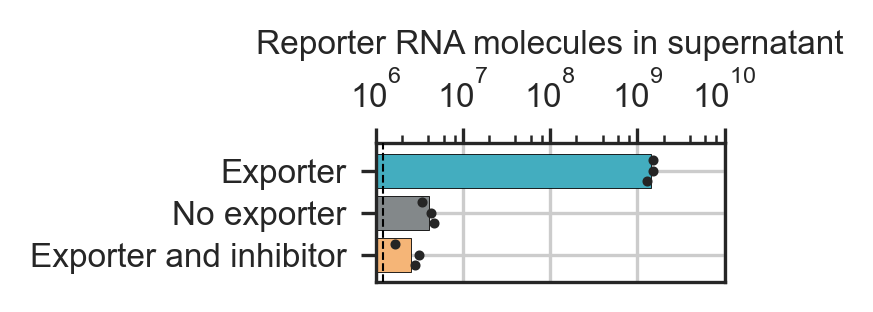

In [14]:
# Make simple swarm plot

field = "RNA molecules censored"

fig, ax = plt.subplots(1, 1, figsize=(1.5,0.6))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_xscale("log")
ax.set_xlim(1e6, 1e10)

# Plot summary

x = summary_subset[field]
y = np.arange(len(x))
color = ["#43adbf", "#83888a", "#f5b577"]

ax.barh(width=x, y=y, color=color, edgecolor="#010101", lw=0.2)

# # Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

x_swarm = data[field]
y_swarm = np.array([y[rank] for rank in data["rank"]])

y_offset = np.array([-0.25, 0, 0.25])  # jitter offsets to avoid operlaps
y_swarm_offset = y_swarm + np.tile(y_offset, int(len(y_swarm)/len(y_offset)))

ax.scatter(x_swarm, y_swarm_offset, color="#252525", s=2, zorder=10)

# Set axis aesthetics
ax.set_ylim(y[0]-0.65, y[-1]+0.65)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Reporter RNA molecules in supernatant", labelpad=4)
ax.set_ylabel("")
ax.set_yticks(y)
ax.grid(True)

# Set xaxis tick spacing
locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Set tick labels
ax.set_yticks([0, 1, 2])
yticklabels = ["Exporter", "No exporter", "Exporter and inhibitor"]
ax.set_yticklabels(yticklabels)

# Show limit of detection
ax.axvline(LOD, ls="--", color="k", lw=0.5, zorder=10)

save_figure(fig, "barplot_inhibitor")